<a href="https://colab.research.google.com/github/supsi-dacd-isaac/TeachDecisionMakingUncertainty/blob/main/L07/data_driven_MaximumLikelihood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Maximum Likelihood Estimation for a Normal Distribution

This document demonstrates how to perform Maximum Likelihood Estimation (MLE) to estimate the parameters (mean and standard deviation) of a normal distribution using Python.

See also:
http://probabilitycourse.com/chapter8/8_2_3_max_likelihood_estimation.php

for more details and examples


## Introduction

MLE is a method used to estimate the parameters of a statistical model. In the context of a normal distribution, MLE can be used to estimate the mean (μ) and standard deviation (σ) that best fit the observed data.



First, we generate a sample dataset of 100 data points drawn from a normal distribution with a true mean of 5 and a standard deviation of 2.


## Defining the Negative Log-Likelihood Function for a Normal Distribution

In statistical modeling, the **Negative Log-Likelihood (NLL)** is a measure used to assess the fit of a probability distribution to a set of observed data. For a normal (Gaussian) distribution, the NLL function quantifies how well the parameters of the distribution (mean and standard deviation) explain the observed data.

### Likelihood Function

Given a set of independent and identically distributed data points $x_1, x_2, \ldots, x_n $ drawn from a normal distribution with mean $\mu$ and variance $\sigma^2 $, the likelihood function $L(\mu, \sigma^2)$ is the joint probability density of observing the given data under the specified parameters:

$$
L(\mu, \sigma^2) = \prod_{i=1}^n \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(x_i - \mu)^2}{2\sigma^2}\right)
$$

### Log-Likelihood Function

To simplify the computation, we often work with the natural logarithm of the likelihood function, known as the log-likelihood function:

$$
\ln L(\mu, \sigma^2) = -\frac{n}{2} \ln(2\pi) - \frac{n}{2} \ln(\sigma^2) - \frac{1}{2\sigma^2} \sum_{i=1}^n (x_i - \mu)^2
$$
 .



In [35]:
import numpy as np
from scipy.stats import norm

# Set seed for reproducibility
np.random.seed(42)

# Generate 100 data points from a normal distribution with true mean=5 and std=2
sample_data = np.random.normal(loc=5, scale=2, size=100)


def negative_log_likelihood(params, data):
    mu, sigma = params
    n = len(data)
    return 0.5 * n * np.log(2 * np.pi * sigma**2) + np.sum((data - mu)**2) / (2 * sigma**2)

from scipy.optimize import minimize

# Initial guesses for mu and sigma
initial_params = [np.mean(sample_data), np.std(sample_data)]

# Minimize the negative log-likelihood
result = minimize(negative_log_likelihood, initial_params, args=(sample_data,), bounds=[(None, None), (1e-6, None)])

# Extract the MLE estimates
mle_mu, mle_sigma = result.x

print(f"MLE for Mean (mu): {mle_mu}")
print(f"MLE for Standard Deviation (sigma): {mle_sigma}")


MLE for Mean (mu): 4.792306965211812
MLE for Standard Deviation (sigma): 1.8072323532892591


n

Optimized Parameters: [1.67728361 0.41046507 1.87497843 0.97137672 0.28502476]
True Parameters: [1, 0.2, 0.1, 3, 1.1]
Optimization Success: True
Final Cost: -0.9985499332740044


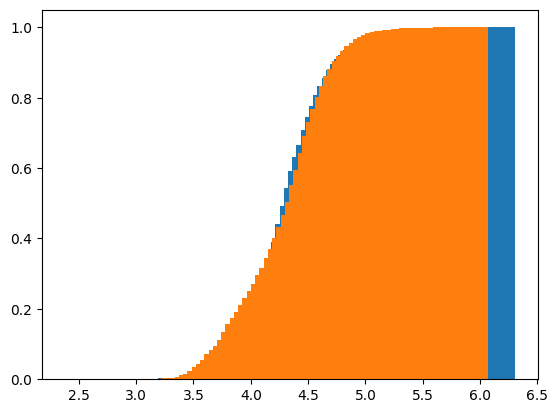

In [34]:
import numpy as np
from scipy.stats import wasserstein_distance as wasserstein
from scipy.optimize import minimize

# Improved likelihood function
def non_parametric_likelihood(params, simulator, data):
    sim_data = simulator(params)
    if sim_data is None or len(sim_data) == 0:  # Handle failure cases
        return 1e6  # Large finite penalty instead of -∞

    probabilistic_distance_distributions = wasserstein(sim_data, data)

    # Adjust likelihood scaling (was too extreme before)
    likelihood = np.exp(-100 * probabilistic_distance_distributions / len(data))

    return -likelihood  # NEGATIVE for maximization

# Improved simulator function
def example_stochastic_simulator(params, n_samples=5000):  # Increased samples
    mu, std, a1, a2, a3 = params

    if std <= 0:  # Prevent invalid standard deviation
        return None

    noise1 = np.random.normal(loc=mu, scale=std, size=n_samples)
    noise2 = np.random.normal(loc=mu, scale=std, size=n_samples)
    out = a1 + a2 * noise1 + a3 * noise2  + np.sin(a2 * noise1 * noise2)

    return out

# True parameters
true_parameters = [1, 0.2, 0.1, 3, 1.1]

# Sample data with more points for better likelihood estimation
sample_data = example_stochastic_simulator(true_parameters, 5000)  # Use more samples

# Initial guess
initial_params = [0.5, 0.1, 0.1, 0.1, 0.1]

# Bounds to ensure `std` is positive
bounds = [(None, 2),  # mu unrestricted
          (1e-4, 2),  # std > 0
          (0, 2),   # a1 unrestricted
          (0, 2),   # a2 unrestricted
          (0, 2)]   # a3 unrestricted

# Try Powell (better for non-smooth optimization)
result = minimize(non_parametric_likelihood, initial_params, args=(example_stochastic_simulator, sample_data), bounds=bounds, method="Powell")

# Extract the MLE estimates
mle_params = result.x

print("Optimized Parameters:", mle_params)
print("True Parameters:", true_parameters)
print("Optimization Success:", result.success)
print("Final Cost:", result.fun)

import matplotlib.pyplot as plt
plt.hist(sample_data, cumulative=True, density=True, bins=100)
plt.hist(example_stochastic_simulator(mle_params), cumulative=True, density=True, bins=100)
plt.show()

